In [22]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import math
import os

In [23]:
#convinience function
path_models = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","models")
path_scenes = os.path.join("product-recognition-on-store-shelves-images","object_detection_project","scenes")

def get_path_model(index):
    return os.path.join(path_models, f"{index}.jpg")

def get_path_scene(index):
    return os.path.join(path_scenes, f"{index}")

def rotate_tuple(point, angle_degrees):
    """
    Rotates a 2D tuple (point) by a given angle in degrees.

    Args:
        point: A tuple (x, y).
        angle_degrees: Angle to rotate the point, in degrees.

    Returns:
        A tuple (x', y') representing the rotated point.
    """
    # Convert angle to radians
    angle_radians = math.radians(angle_degrees)

    # Extract the x and y coordinates
    x, y = point

    # Apply the rotation matrix
    x_rotated = x * math.cos(angle_radians) - y * math.sin(angle_radians)
    y_rotated = x * math.sin(angle_radians) + y * math.cos(angle_radians)

    return (x_rotated, y_rotated)

def multiply_tuple(point, scale):
    return tuple(element * scale for element in point)

def add_tuple(x, y):
    return (x[0] + y[0], x[1] + y[1])

-------------------------------------------
Looking for 0.jpg...
Not enough matches are found - 60/100
-------------------------------------------
Looking for 1.jpg...
Not enough matches are found - 19/100
-------------------------------------------
Looking for 2.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 3.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 4.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 5.jpg...
Not enough matches are found - 56/100
-------------------------------------------
Looking for 6.jpg...
Not enough matches are found - 47/100
-------------------------------------------
Looking for 7.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 8.jpg...
Not enough matches are found - 2/100
-------------------------------------------
Looking for 9.jpg...
Not enough ma

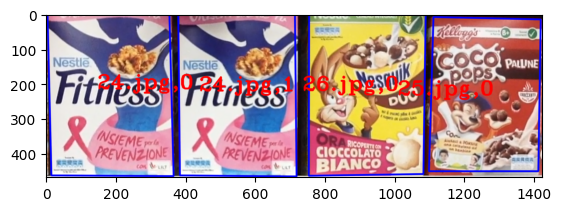

In [24]:
def find_image(scene_path, model_paths, draw_on_color=True):
    target_resolution = (150, 210)
    scene_gray = cv.imread(scene_path,cv.IMREAD_GRAYSCALE)

    scene_to_draw_on = cv.imread(scene_path) if draw_on_color else scene_gray

    #create array with all models
    models = []
    for model_gray_path in model_paths:

        name = os.path.split(model_gray_path)[-1]
        models.append({
            "name": name,
            "img": cv.imread(model_gray_path, cv.IMREAD_GRAYSCALE)
            })

    for model in models:
        print("-------------------------------------------")
        print(f"Looking for {model["name"]}...")

        #model_gray = model["img"]
        _model_gray = model["img"]
        model_gray = cv.resize(_model_gray, target_resolution, interpolation=cv.INTER_AREA)
        MIN_MATCH_COUNT = 100

        # Initiate SIFT detector
        sift = cv.SIFT_create()

        # find the keypoints and descriptors with SIFT
        kp_model, des1 = sift.detectAndCompute(model_gray,None)
        kp_scene, des2 = sift.detectAndCompute(scene_gray,None)

        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1,des2,k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7 * n.distance:
                good.append(m)

        scene_to_draw_on = scene_to_draw_on if scene_to_draw_on is not None else scene_gray

        result = scene_to_draw_on

        if len(good)>MIN_MATCH_COUNT:
            print( "Enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            """src_pts = [ kp1[m.queryIdx] for m in good ]
            dst_pts = [ kp2[m.trainIdx] for m in good ]

            #bary_src = sum(key_pt.pt for key_pt in src_pts)/len(src_pts)
            #print(bary_src)

            bary_src = (0,0)
            for key_pt in src_pts:
                bary_src = (bary_src[0] + key_pt.pt[0], bary_src[1] + key_pt.pt[1])
            bary_src = (bary_src[0]/len(src_pts), bary_src[1]/len(src_pts))
            print(bary_src)

            #img_visualization = cv.drawKeypoints(model_gray,src_pts,None,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            #plt.imshow(img_visualization)
            #plt.show()

            joint_vec_src = []
            for key_pt in src_pts:
                vec = (key_pt.pt[0] - bary_src[0], key_pt.pt[1] - bary_src[1])
                joint_vec_src.append(vec)

            bary_vote_dst = []
            for i in range(len(dst_pts)):
                rot = dst_pts[i].angle - src_pts[i].angle
                scale = dst_pts[i].size / src_pts[i].size
                bary = add_tuple(src_pts[i].pt, multiply_tuple(rotate_tuple(joint_vec_src[i], rot), scale))
                bary_vote_dst.append(bary)

            for point in bary_vote_dst:
                # Draw a circle at each coordinate
                cv.circle(scene_gray, (int(point[0]), int(point[1])), radius=5, color=(0, 255, 0), thickness=-1)  # Green filled circle

            # Show the image
            cv.imshow("Image with Points", scene_gray)
            cv.waitKey(0)
            cv.destroyAllWindows()"""

            src_kp = [kp_model[m.queryIdx] for m in good]
            dst_kp = [kp_scene[m.trainIdx] for m in good]


            #calculate barycenter of model
            x = 0
            y = 0
            for kp in src_kp:
                x_kp, y_kp = kp.pt
                x += x_kp
                y += y_kp
            barycenter = np.array([int(x/len(src_kp)), int(y/len(src_kp))])

            #draw barycenter
            tmp = model_gray.copy()
            #cv.circle(tmp, barycenter, 3, (0,0,255), 2)
            #plt.imshow(tmp)
            #plt.show()

            # calculate joining vectors of model
            joining_vectors = []
            for kp in src_kp:
                x, y = kp.pt
                v = barycenter - [int(x), int(y)]
                joining_vectors.append(v)

            barycenter_votes = []

            tmp = scene_to_draw_on.copy()
            for s, d, jv in zip(src_kp, dst_kp, joining_vectors):

                if jv is None:
                    raise Exception("there must be the same point in")

                jv_x, jv_y = jv

                pt_x, pt_y = d.pt
                delta_s = d.size/s.size

                #delta_phi = d.angle/s.angle
                delta_phi = d.angle - s.angle

                angle_radians = math.radians(delta_phi)
                jv_x_rot = jv_x * math.cos(angle_radians) - jv_y * math.sin(angle_radians)
                jv_y_rot = jv_x * math.sin(angle_radians) + jv_y * math.cos(angle_radians)

                bary_predict = [int(pt_x + delta_s * jv_x_rot), int(pt_y + delta_s * jv_y_rot)]
                barycenter_votes.append(bary_predict)

                #cv.line(tmp, bary_predict, [int(pt_x), int(pt_y)], (0,0,255), 1)

            #plt.imshow(tmp)
            #plt.show()


            GRID_RESOLUTION = 15
            #MIN_VOTES = 25
            MIN_VOTES = int(len(good)/4)
            x_cell = scene_gray.shape[1]/GRID_RESOLUTION
            y_cell = scene_gray.shape[0]/GRID_RESOLUTION
            #grid = np.zeros((GRID_RESOLUTION, GRID_RESOLUTION))

            # Initialize a 2D array where each element is an empty list
            grid = [[[] for _ in range(GRID_RESOLUTION)] for _ in range(GRID_RESOLUTION)]

            #print("Scene:", scene_gray.shape)
            #print("Grid:", grid)

            for i in range(0,len(barycenter_votes)):
                bary = barycenter_votes[i]
                # Check if predict Bary center is in Picture
                if 0 < bary[0] < scene_gray.shape[1] and 0 < bary[1] < scene_gray.shape[0]:
                    x_idx = int(bary[0]/x_cell)
                    y_idx = int(bary[1]/y_cell)
                    #print((x_idx, y_idx))
                    grid[x_idx][y_idx].append((src_kp[i], dst_kp[i]))
                else:
                    print("barycenter votes out of range")

            """grid_lens = np.zeros((GRID_RESOLUTION,GRID_RESOLUTION))
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    grid_lens[i][j] = len(grid[i][j])
            print(grid_lens)"""

            winners = []
            for i in range(0,len(grid)):
                for j in range(0,len(grid[i])):
                    if len(grid[i][j])>=MIN_VOTES:
                        print("Enough Votes are found - {}/{}".format(len(grid[i][j]), MIN_VOTES))
                        #print(f"({i},{j}):{len(grid[i][j])}")
                        winners.append(grid[i][j])
                    else:
                        if len(grid[i][j])>0:
                            print("Not Enough Votes are found - {}/{}".format(len(grid[i][j]), MIN_VOTES))

            i = 0
            for winner in winners:
                #USE THIS TO DRAW THE RESULTS FROM POINTS
                src_pts = np.float32([ kp[0].pt for kp in winner ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp[1].pt for kp in winner ]).reshape(-1,1,2)
                M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
                matchesMask = mask.ravel().tolist()
                h,w = model_gray.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,
                                                h-1],[w-1,0] ]).reshape(-1,1,2)

                dst = cv.perspectiveTransform(pts,M)

                #add square and add text
                means = np.mean(dst, axis=0)
                x, y = [a for a in means[0]]
                x = x * 0.8 #adjust for text

                result = cv.polylines(scene_to_draw_on,[np.int32(dst)],True,255,3, cv.LINE_AA)

                boldness = 3
                size = 3
                cv.putText(scene_to_draw_on, f"{model["name"]},{i}", (int(x),int(y)), cv.FONT_HERSHEY_COMPLEX_SMALL, size, (0, 0, 255, 255), boldness, cv.LINE_AA)
                i = i + 1

        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None

    #print("------------------------------------------")
    #print("Results:")
    return result


#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m1.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

-------------------------------------------
Looking for 0.jpg...
Enough matches are found - 206/100
Not Enough Votes are found - 5/51
Enough Votes are found - 145/51
Not Enough Votes are found - 1/51
Enough Votes are found - 52/51
Not Enough Votes are found - 3/51
-------------------------------------------
Looking for 1.jpg...
Not enough matches are found - 76/100
-------------------------------------------
Looking for 2.jpg...
Not enough matches are found - 7/100
-------------------------------------------
Looking for 3.jpg...
Not enough matches are found - 0/100
-------------------------------------------
Looking for 4.jpg...
Not enough matches are found - 4/100
-------------------------------------------
Looking for 5.jpg...
Not enough matches are found - 70/100
-------------------------------------------
Looking for 6.jpg...
Not enough matches are found - 70/100
-------------------------------------------
Looking for 7.jpg...
Not enough matches are found - 1/100
------------------

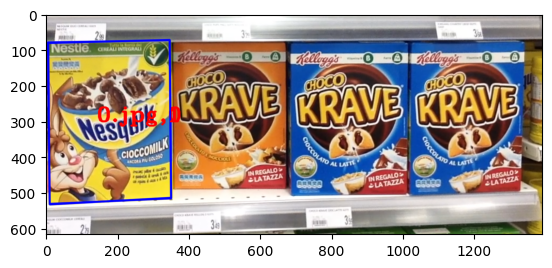

In [25]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m2.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

-------------------------------------------
Looking for 0.jpg...
Not enough matches are found - 68/100
-------------------------------------------
Looking for 1.jpg...
Not enough matches are found - 14/100
-------------------------------------------
Looking for 2.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 3.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 4.jpg...
Not enough matches are found - 3/100
-------------------------------------------
Looking for 5.jpg...
Not enough matches are found - 52/100
-------------------------------------------
Looking for 6.jpg...
Not enough matches are found - 65/100
-------------------------------------------
Looking for 7.jpg...
Not enough matches are found - 0/100
-------------------------------------------
Looking for 8.jpg...
Not enough matches are found - 0/100
-------------------------------------------
Looking for 9.jpg...
Not enough ma

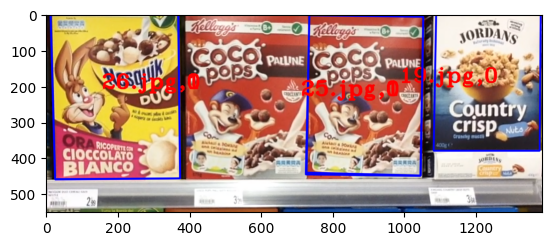

In [26]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m3.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

-------------------------------------------
Looking for 0.jpg...
Not enough matches are found - 46/100
-------------------------------------------
Looking for 1.jpg...
Not enough matches are found - 12/100
-------------------------------------------
Looking for 2.jpg...
Not enough matches are found - 3/100
-------------------------------------------
Looking for 3.jpg...
Not enough matches are found - 0/100
-------------------------------------------
Looking for 4.jpg...
Not enough matches are found - 3/100
-------------------------------------------
Looking for 5.jpg...
Not enough matches are found - 38/100
-------------------------------------------
Looking for 6.jpg...
Not enough matches are found - 38/100
-------------------------------------------
Looking for 7.jpg...
Not enough matches are found - 2/100
-------------------------------------------
Looking for 8.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 9.jpg...
Not enough ma

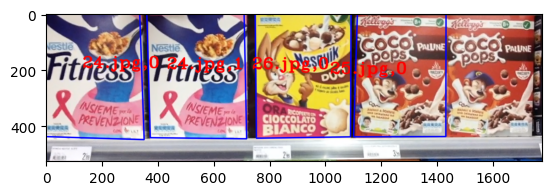

In [27]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m4.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()

-------------------------------------------
Looking for 0.jpg...
Not enough matches are found - 2/100
-------------------------------------------
Looking for 1.jpg...
Not enough matches are found - 70/100
-------------------------------------------
Looking for 2.jpg...
Not enough matches are found - 3/100
-------------------------------------------
Looking for 3.jpg...
Not enough matches are found - 0/100
-------------------------------------------
Looking for 4.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 5.jpg...
Not enough matches are found - 4/100
-------------------------------------------
Looking for 6.jpg...
Not enough matches are found - 2/100
-------------------------------------------
Looking for 7.jpg...
Not enough matches are found - 0/100
-------------------------------------------
Looking for 8.jpg...
Not enough matches are found - 1/100
-------------------------------------------
Looking for 9.jpg...
Not enough match

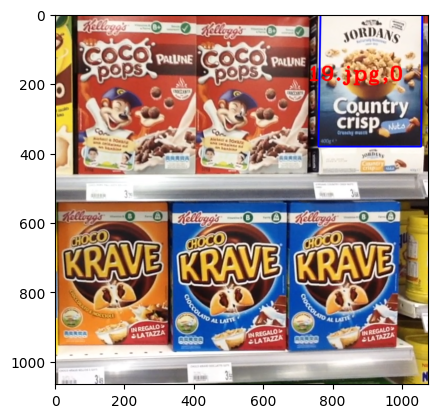

In [28]:
#define models to be searched in image
models = [get_path_model(a) for a in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]]
#[0,1,11,19,24,25,26]]
result = find_image(scene_path=get_path_scene("m5.png"),
                    model_paths=models,
                    draw_on_color=True)

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()